In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import amlrealtimeai
from amlrealtimeai import resnet50

import h5py

In [2]:
# Input images as a two-dimensional tensor containing an arbitrary number of images represented a strings
import amlrealtimeai.resnet50.utils
in_images = tf.placeholder(tf.string)
image_tensors = resnet50.utils.preprocess_array(in_images)
image_tensors = tf.placeholder(tf.int32,shape=(None,224, 224, 3))

In [3]:
subscription_id = "80defacd-509e-410c-9812-6e52ed6a0016"
resource_group = "CMS_FPGA_Resources"
model_management_account = "CMS_FPGA_1"

from amlrealtimeai.resnet50.model import RemoteQuantizedResNet50
model_path = os.path.expanduser('~/models')
featurizer = RemoteQuantizedResNet50(subscription_id, resource_group, model_management_account, model_path)
print(featurizer.version)

Using TensorFlow backend.


To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code E2U5LKGE7 to authenticate.
1.1.6-rc


In [4]:
featurizer.import_graph_def(include_top=False, input_tensor=image_tensors)
features = featurizer.featurizer_output

Registering model resnet50-1.1.6-rc-model
Successfully registered model resnet50-1.1.6-rc-model
Creating service featurizer-service-08cdb9
. . . . . . . . . 
Successfully created service featurizer-service-08cdb9


In [25]:
# Load data
f = h5py.File("//Users/atsaris/mygit_repos/ml_service/datasets/HDF5Images/train.h5",'r')
images = np.array(f['data'])
labels = np.array(f['label'])
labels = labels.reshape(labels.shape[0])
f.close()

fM = h5py.File("//Users/atsaris/mygit_repos/ml_service/datasets/RandomData/hdf5/mnist_test.hdf5",'r')
imagesM = np.array(fM['features'])
labelsM = np.array(fM['targets'])
labelsM = labelsM.reshape(labelsM.shape[0])
fM.close()

NOvA: (10, 2, 100, 80)
MNIST: (10, 1, 28, 28)
(10, 100, 160, 1)
NOvA new: (10, 100, 80, 1)
MNIST new: (10, 28, 28, 1)
NOvA new new: (10, 224, 224, 3)
MNIST new new: (10, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


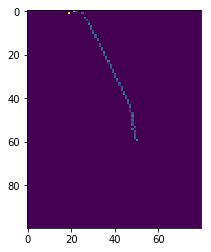

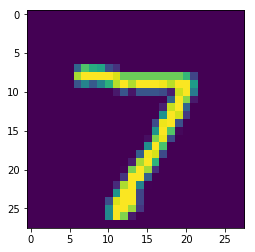

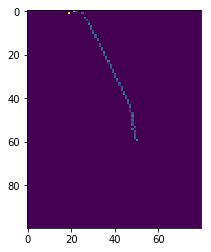

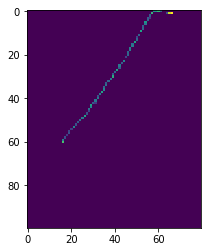

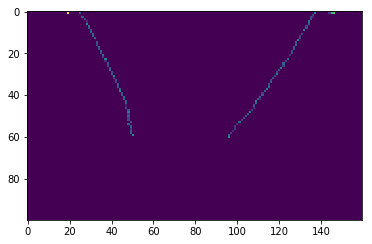

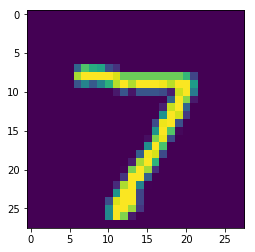

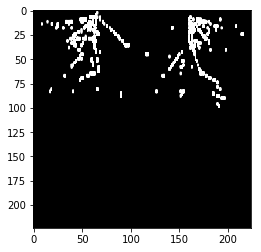

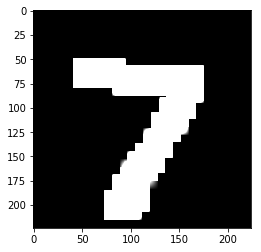

In [26]:
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

NUMBER_OF_DATA = 10
imagesM = imagesM[:NUMBER_OF_DATA]

print("NOvA:", images.shape)
print("MNIST:", imagesM.shape)
plt.figure()
plt.imshow(images[0][0, :, :])
plt.figure()
plt.imshow(imagesM[0][0, :, :])

images1 = images[:, 0, :, :]
images2 = images[:, 1, :, :]
images1 = images1.reshape(images1.shape[0], images1.shape[1], images1.shape[2], 1).astype('float32')
images2 = images2.reshape(images2.shape[0], images2.shape[1], images2.shape[2], 1).astype('float32')
images = np.concatenate((images1, images2), axis=2)
#images = np.stack((images1, images2), axis=0)
print(images.shape)
imagesM = imagesM.reshape(imagesM.shape[0], imagesM.shape[2], imagesM.shape[3], imagesM.shape[1]).astype('float32')

print("NOvA new:", images1.shape)
print("MNIST new:", imagesM.shape)
plt.figure()
plt.imshow(images1[0][:, :, 0])
plt.figure()
plt.imshow(images2[0][:, :, 0])
plt.figure()
plt.imshow(images[0][:, :, 0])
plt.figure()
plt.imshow(imagesM[0][:, :, 0])


sess = tf.Session()
with sess.as_default():
    images_tf = tf.image.grayscale_to_rgb(images)
    images_tf = tf.image.resize_images(images_tf, [224,224])
    images = images_tf.eval()
    
sess = tf.Session()
with sess.as_default():
    imagesM_tf = tf.image.grayscale_to_rgb(imagesM)
    imagesM_tf = tf.image.resize_images(imagesM_tf, [224,224])
    imagesM = imagesM_tf.eval()

print("NOvA new new:", images.shape)    
print("MNIST new new:", imagesM.shape)    
plt.figure()
plt.imshow(images[0])
plt.figure()
plt.imshow(imagesM[0])

In [11]:
featurizer.cleanup_remote_service()

Deleting service 8f37d662198a471aaacefa5f1f047b53
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Deleted service 8f37d662198a471aaacefa5f1f047b53
Deleting model 3f632e76b4d643f3af10db21707ea205
Deleted model 3f632e76b4d643f3af10db21707ea205


In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Flatten
from keras import optimizers

FC_SIZE = 1024
NUM_CLASSES = 10

model = Sequential()
model.add(Dropout(0.2, input_shape=(1, 1, 2048,)))
model.add(Dense(FC_SIZE, activation='relu', input_dim=(1, 1, 2048,)))
model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='sigmoid', input_dim=FC_SIZE))

model.compile(optimizer=optimizers.SGD(lr=1e-4,momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

onehot_labels = np_utils.to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(feature_results, onehot_labels[:NUMBER_OF_DATA], random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

ValueError: Found input variables with inconsistent numbers of samples: [1, 100]

In [26]:
model.fit(X_train, y_train, epochs=16, batch_size=32)

Epoch 1/16
3750/3750 [==============================] - 1s 357us/step - loss: 0.4392 - acc: 0.8290
Epoch 2/16
3750/3750 [==============================] - 1s 302us/step - loss: 0.3307 - acc: 0.9001
Epoch 3/16
3750/3750 [==============================] - 1s 310us/step - loss: 0.3177 - acc: 0.8998
Epoch 4/16
3750/3750 [==============================] - 1s 296us/step - loss: 0.3063 - acc: 0.9000
Epoch 5/16
3750/3750 [==============================] - 1s 323us/step - loss: 0.2950 - acc: 0.9003
Epoch 6/16
3750/3750 [==============================] - 1s 315us/step - loss: 0.2855 - acc: 0.9006
Epoch 7/16
3750/3750 [==============================] - 1s 307us/step - loss: 0.2767 - acc: 0.9015
Epoch 8/16
3750/3750 [==============================] - 1s 344us/step - loss: 0.2691 - acc: 0.9037
Epoch 9/16
3750/3750 [==============================] - 1s 363us/step - loss: 0.2617 - acc: 0.9039
Epoch 10/16
3750/3750 [==============================] - 1s 348us/step - loss: 0.2566 - acc: 0.9051
Epoch 11/

In [27]:
from numpy import argmax

y_probs = model.predict(X_test)
y_prob_max = np.argmax(y_probs, 1)
y_test_max = np.argmax(y_test, 1)
print(y_probs)
print(y_prob_max)
print(y_test_max)

[[0.1560993  0.03441066 0.08566981 ... 0.03987736 0.09790856 0.25913006]
 [0.01599598 0.0183213  0.15232992 ... 0.05271259 0.05910967 0.03342381]
 [0.01837717 0.01035685 0.15882698 ... 0.06471109 0.02867143 0.02676922]
 ...
 [0.1105858  0.2316812  0.09542499 ... 0.10809521 0.10976887 0.138979  ]
 [0.01865262 0.13551237 0.04361216 ... 0.2581135  0.01753661 0.03760817]
 [0.09109724 0.03042813 0.26713908 ... 0.04508406 0.06173834 0.03381212]]
[9 3 3 ... 1 4 2]
[9 5 5 ... 9 7 2]


Accuracy 0.6936
Precision [0.65359477 0.7740113  0.47826087 0.52777778 0.83453237 0.71698113
 0.83783784 0.79381443 0.76515152 0.78512397]
Recall [0.96153846 0.99275362 0.69369369 0.84821429 0.8        0.27737226
 0.24409449 0.58778626 0.81451613 0.78512397]
F1 [0.77821012 0.86984127 0.56617647 0.65068493 0.81690141 0.4
 0.37804878 0.6754386  0.7890625  0.78512397]
Confusion Matrix [[100, 0, 1, 0, 1, 0, 0, 0, 0, 2], [0, 137, 0, 0, 0, 0, 0, 1, 0, 0], [8, 7, 77, 4, 0, 2, 1, 5, 5, 2], [0, 0, 7, 95, 0, 4, 1, 0, 4, 1], [1, 5, 12, 0, 116, 0, 0, 10, 0, 1], [5, 0, 18, 73, 0, 38, 0, 1, 1, 1], [31, 4, 19, 4, 1, 1, 31, 2, 20, 14], [1, 22, 14, 0, 16, 1, 0, 77, 0, 0], [2, 0, 8, 3, 0, 3, 2, 0, 101, 5], [5, 2, 5, 1, 5, 4, 2, 1, 1, 95]]


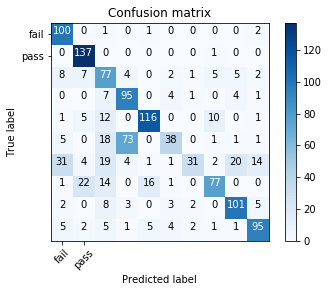

In [28]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import itertools
import matplotlib
from matplotlib import pyplot as plt

# compute a bunch of classification metrics 
def classification_metrics(y_true, y_pred, y_prob):
    cm_dict = {}
    cm_dict['Accuracy'] = accuracy_score(y_true, y_pred)
    cm_dict['Precision'] =  precision_score(y_true, y_pred, average=None)
    cm_dict['Recall'] =  recall_score(y_true, y_pred, average=None)
    cm_dict['F1'] =  f1_score(y_true, y_pred, average=None) 
    #cm_dict['AUC'] = roc_auc_score(y_true, y_prob[:,0])
    cm_dict['Confusion Matrix'] = confusion_matrix(y_true, y_pred).tolist()
    return cm_dict

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """Plots a confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    New BSD License - see appendix
    """
    cm_max = cm.max()
    cm_min = cm.min()
    if cm_min > 0: cm_min = 0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_max = 1
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm_max / 2.
    plt.clim(cm_min, cm_max)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,
                 round(cm[i, j], 3),  # round to 3 decimals if they are float
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
cm_dict = classification_metrics(y_test_max, y_prob_max, y_probs)
for m in cm_dict:
    print(m, cm_dict[m])
cm = np.asarray(cm_dict['Confusion Matrix'])
plot_confusion_matrix(cm, ['fail','pass'], normalize=False)